# Pre-computing the APOGEE-1 and 2 DR17 selection function

In this notebook, we will run through the computation of the DR17 selection function.

To do this, you will need the [`apogee`](https://github.com/jobovy/apogee) and [`mwdust`](https://github.com/jobovy/mwdust) python packages. You should also ensure that you have the set of low metallicity isochrones from PARSEC.

In [1]:
import os
import sys

os.environ['DUST_DIR'] = '/Users/dhortadarrington/Packages/mwdust/'

import numpy as np
import matplotlib.pyplot as plt
import mwdust
import tqdm
import dill as pickle
import multiprocessing
import utils
import densprofiles
from isodist import FEH2Z, Z2FEH
import corner
import matplotlib
import safe_colours
from galpy.util import plot #only necessary if you want to plot...
import os
import sys
import matplotlib.patheffects as PathEffects
import dill as pickle
import astropy.io.fits as fits
import cmasher as cm
from scipy.interpolate import interp1d

os.environ['RESULTS_VERS'] = 'dr17'
os.environ['SDSS_LOCAL_SAS_MIRROR'] = '/Users/dhortadarrington/Documents/Projects/halo-density/data/'
os.environ['ISODIST_DATA'] = '/Users/dhortadarrington/Packages/isodist/'

# https://github.com/astrojimig/apogee/tree/dr17-selection
sys.path.insert(1,'/Users/dhortadarrington/Packages/apogee/')

import apogee.select as apsel
import apogee.tools.read as apread

columnwidth = 240./72.27
textwidth = 504.0/72.27


A new version of galpy (1.10.0) is available, please upgrade using pip/conda/... to get the latest features and bug fixes!


# The 'raw' selection function

First, we need to evaluate or load up the combined APOGEE-1 and 2 selection function, which is a function of the dereddened $(J-K_s)_0$ colour and apparent $H$ magnitude.

We will also determine, for the sample loaded above, which stars are in the 'statistical sample' for APOGEE-1 and 2. This is the subset of stars which are in completed observation cohorts.

In [2]:
force = False
if os.path.exists('../sav/apogeeCombinedSF_DR17.dat') and not force:
    with open('../sav/apogeeCombinedSF_DR17.dat', 'rb') as f:
        apo = pickle.load(f)
else:
    apo = apsel.apogeeCombinedSelect(year=10)
    with open('../sav/apogeeCombinedSF_DR17.dat', 'wb') as f:
        pickle.dump(apo, f)
force = False


We can then make a plot showing the selection fraction as function of sky position and colour-magnitude bin:

In [3]:
#Coordinates from the Selection Function
aposel_glons = np.array([apo.glonGlat(x)[0][0] for x in apo._locations])
aposel_glats = np.array([apo.glonGlat(x)[1][0] for x in apo._locations])

In [4]:
from matplotlib import rc
rc('font',**{'family':'serif','serif':['Times']})
rc('text', usetex=True)

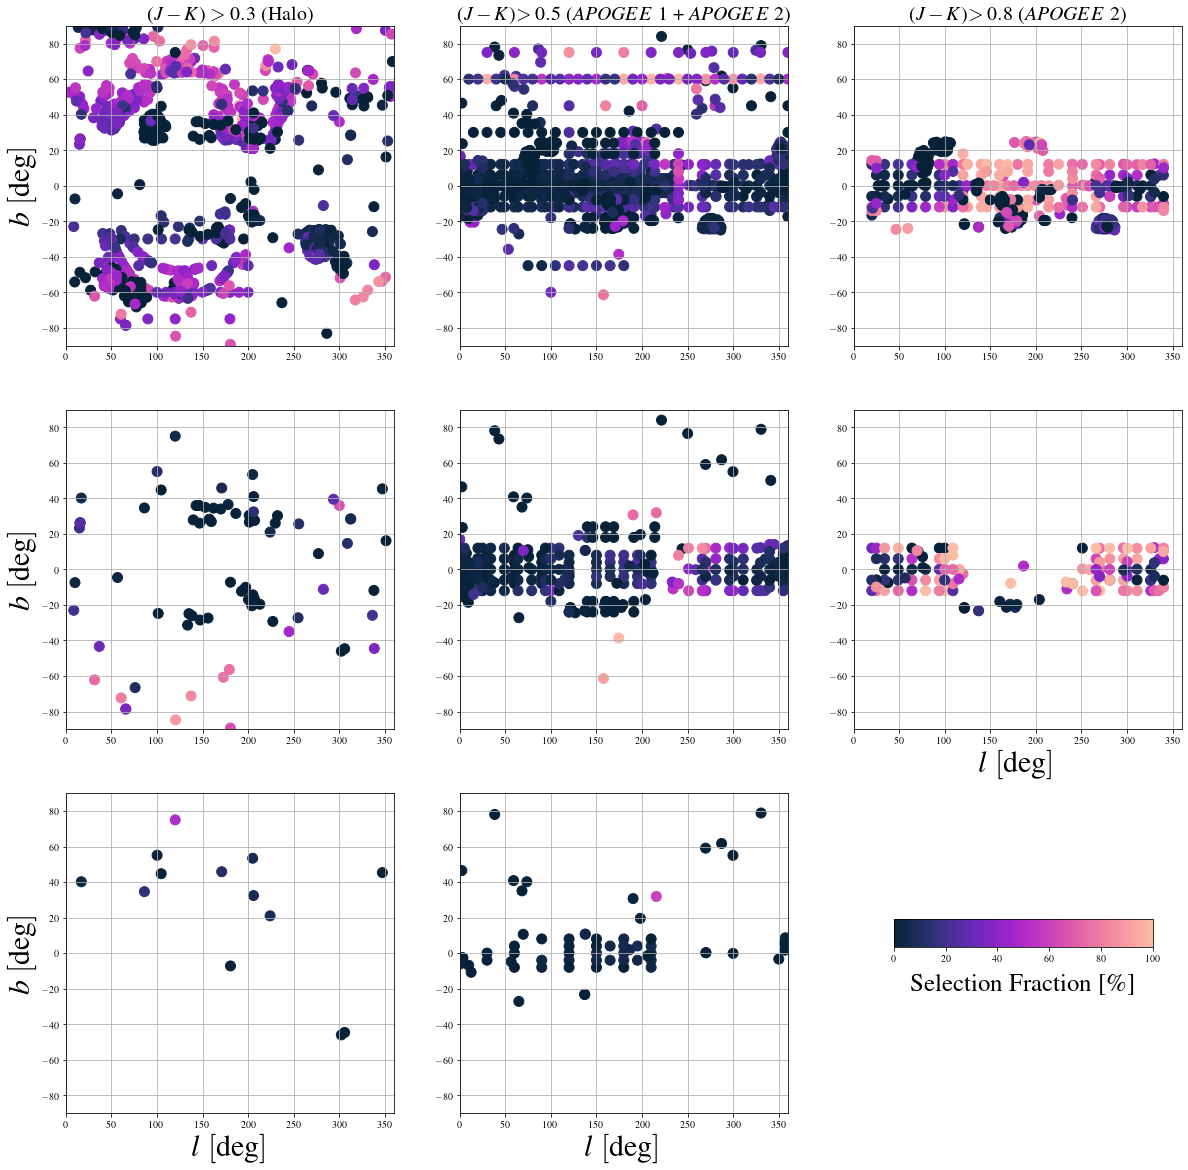

In [5]:
#Set up Figure
fig = plt.figure(figsize=(20,20), facecolor='white')
xlabel = r'$l\ \mathrm{[deg]}$'
ylabel = r'$b\ \mathrm{[deg]}$'
anno_x, anno_y = 210,-70
#fig.set_size_inches(20,20)

def plot_selfunc_grid(cohort,colorbin):
    mask3 = []
    mask5 = []
    mask8 = []
    for l in apo._locations:
        if round(apo.JKmax(l),2) == 0.8:
            mask8.append(True)
        else:
            mask8.append(False)
            
        if round(apo.JKmin(l),2) == 0.3:
            mask3.append(True)
        else:
            mask3.append(False)
            
        if round(apo.JKmin(l),2) == 0.5:
            mask5.append(True)
        else:
            mask5.append(False)
                
    if cohort == 'short':
        sel_fractions = (apo._nspec_short/apo._nphot_short)
        
    if cohort == 'medium':
        sel_fractions = (apo._nspec_medium/apo._nphot_medium)
        
    if cohort == 'long':
        sel_fractions = (apo._nspec_long/apo._nphot_long)
        
    if colorbin == 0.3:
        sel_fractions = sel_fractions.T[0]*100
        m = mask3

    elif colorbin == 0.5:
        sel_fractions = sel_fractions.T[0]*100
        m = mask5
        
    elif colorbin == 0.8:
        sel_fractions = sel_fractions.T[1]*100
        m = mask8
        
    plt.grid()
    plt.xlim(0,360)
    plt.ylim(-90,90)
    plt.scatter(aposel_glons[m],aposel_glats[m],c=sel_fractions[m],vmin=0,vmax=100,cmap=cm.bubblegum, s=100)
    return

    
plt.subplot(3,3,1)
plt.title('($J-K$) $> 0.3$ (Halo)', fontsize=20)
plot_selfunc_grid('short',0.3)
plt.ylabel(ylabel, fontsize=30)
# plt.text(20,70, 'short cohort')

plt.subplot(3,3,2)
#Short Cohort, (J-K)>0.5
plt.title('($J-K$)$>0.5$ ($APOGEE$ 1 + $APOGEE$ 2)', fontsize=20)
plot_selfunc_grid('short',0.5)

plt.subplot(3,3,3)
#Short Cohort, (J-K)>0.8
plt.title('($J-K$)$>0.8$ ($APOGEE$ 2)', fontsize=20)
plot_selfunc_grid('short',0.8)


plt.subplot(3,3,4)
#Medium Cohort,(J-K)>0.3
plot_selfunc_grid('medium',0.3)
plt.ylabel(ylabel, fontsize=30)
# plt.text(20,70, 'medium cohort')


plt.subplot(3,3,5)
#Medium Cohort,(J-K)>0.5
plot_selfunc_grid('medium',0.5)

plt.subplot(3,3,6)
#Medium Cohort,(J-K)>0.8
plot_selfunc_grid('medium',0.8)
plt.xlabel(xlabel, fontsize=30)

plt.subplot(3,3,7)
#Long Cohort, (J-K)>0.3
plot_selfunc_grid('long',0.3)
plt.ylabel(ylabel, fontsize=30)
plt.xlabel(xlabel, fontsize=30)
# plt.text(20,70, 'long cohort')


plt.subplot(3,3,8)
#Long Cohort, (J-K)>0.5
plot_selfunc_grid('long',0.5)
plt.xlabel(xlabel, fontsize=30)


cax = fig.add_axes([0.7,0.24,0.18,0.02])
cbar = plt.colorbar(cax=cax, orientation='horizontal')
cbar.set_label(label=r'Selection Fraction [$\%$]',fontsize=25,labelpad=10)

plt.show()



# Computing the effective selection function on a grid of locations and distance modulus

We now need to pre-compute the effective spatial selection function on the same grid which we will later evaluate the proposed density models in our maximum likelihood and MCMC. This requires a set of PARSEC isochrones which we will use for the MC integration of colour magnitude space. We also need the `Combined15` dustmap from [`mwdust`]([https://github.com/jobovy/mwdust])

We need to make two files, one which has the effective selection function for each $\mathrm{[Fe/H]}$ bin that we will adopt in the analysis, and another which is the effective selection function based on the full range of $\mathrm{[Fe/H]}$. If you dont have these already calculated and saved, this can also take a while, even when multiprocessed (by default, this will run on $N_{\mathrm{cores}}/2$).

# Here's the "weights" for the Effective Selection Function

The output of this is what's passed to the Effective Selection Function!

The isochrones I use:
http://stev.oapd.inaf.it/cgi-bin/cmd

Explaining what the "int_IMF" column is better than I can:

> FLUM has been replaced by int_IMF, which is the integral of the IMF under consideration (as selected in the form, in number of stars, and normalised to a total mass of 1 M☉) from 0 up to the current M_ini. **Differences between 2 values of int_IMF give the absolute number of stars occupying that isochrone section per unit mass of stellar population initially born, as expected for the selected IMF.** (http://stev.oapd.inaf.it/cmd_3.6/help.html)



In [8]:
def add_deltaM_column(iso):
    deltaM = []
    logg_min_lim = -1.
    logg_max_lim = 3.6
    for i in tqdm.tqdm_notebook(range(len(iso['Z']))):
        if (iso['Z'][i-1]==iso['Z'][i])&(iso['logageyr'][i-1]==iso['logageyr'][i])==True:
            #Same metallicity and age = same stellar population
            deltaM.append(iso['int_IMF'][i]-iso['int_IMF'][i-1])
        else:
            deltaM.append(iso['int_IMF'][i+1]-iso['int_IMF'][i])

    #Renormalize, so every population sums to 1
    for m in tqdm.tqdm_notebook(set(iso['Z'])):
        for a in set(iso['logageyr']):
            isom = (iso['Z']==m)&(iso['logageyr']==a)&(iso['logg']>=logg_min_lim)&(iso['logg']<=logg_max_lim)
            #logg_min_lim and logg_max_lim are global variables, the logg limits for the giant branch cut
            dmtot = np.sum(np.array(deltaM)[isom])
        for i in range(len(deltaM)):
            if isom[i]==True:
                deltaM[i] = deltaM[i]/dmtot
    return np.array(deltaM)

In [9]:
#load the isochrone grid (make sure this is downloaded first!)
isorec = utils.generate_isogrid()
# isorec = utils.generate_isogrid()

100%|███████████████████████████████████████████| 71/71 [00:01<00:00, 57.57it/s]


In [10]:
deltaM = add_deltaM_column(isorec)
np.save('../sav/deltaM-nrich-schiavon', deltaM)

/var/folders/rq/q7l_wtbx4sx5ky0yrvbk7fgh0000gq/T/ipykernel_29247/3359127559.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm.tqdm_notebook(range(len(iso['Z']))):



  0%|          | 0/1884793 [00:00<?, ?it/s]

/var/folders/rq/q7l_wtbx4sx5ky0yrvbk7fgh0000gq/T/ipykernel_29247/3359127559.py:13: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for m in tqdm.tqdm_notebook(set(iso['Z'])):



  0%|          | 0/120 [00:00<?, ?it/s]

In [11]:
import warnings
warnings.filterwarnings("ignore")

In [12]:
for indx, i in tqdm.tqdm_notebook(enumerate(apo._locations)):
    apo._nspec_short[indx]

0it [00:00, ?it/s]

In [13]:
def sampleiso(N, iso, weights, return_inds=False, return_iso=False, lowfeh=True):
    """
    Sample isochrone recarray iso weighted by lognormal chabrier (2001) IMF
    """
    if lowfeh:
        logagekey = 'logAge'
        zkey = 'Zini'
        jkey, hkey, kkey = 'Jmag', 'Hmag', 'Ksmag'
    else:
        logagekey = 'logageyr'
        zkey = 'Z'
        jkey, hkey, kkey = 'J', 'H', 'K'
#     weights = iso['deltaM']*(10**(iso[logagekey]-9)/iso[zkey])
    sort = np.argsort(weights)
    tinter = interp1d(np.cumsum(weights[sort])/np.sum(weights), range(len(weights[sort])), kind='linear')
    randinds = np.round(tinter(np.random.rand(N))).astype(np.int64)
    if return_inds:
        return randinds, iso[jkey][sort][randinds], iso[hkey][sort][randinds], iso[kkey][sort][randinds]
    elif return_iso:
        return iso[sort][randinds]
    else:
        return iso[jkey][sort][randinds], iso[hkey][sort][randinds], iso[kkey][sort][randinds]
    
def APOGEE_iso_samples(nsamples, rec, weights, fehrange=[-2.5,0], lowfehgrid = True):
    """
    get samples from the isochrones in the apogee selection (including Log(g) cut for giants, and minimum mass)
    """
    trec = np.copy(rec)
    if lowfehgrid:
        logagekey = 'logAge'
        zkey = 'Zini'
        mkey = 'Mini'
        jkey, hkey, kkey = 'Jmag', 'Hmag', 'Ksmag'
        teff = 'logTe'
    else:
        logagekey = 'logageyr'
        zkey = 'Z'
        mkey ='M_ini'
        jkey, hkey, kkey = 'J', 'H', 'K'
        teff = 'teff'

    mask = (trec[jkey]-trec[kkey] > 0.5)  & (Z2FEH(trec[zkey]) > fehrange[0]) & (Z2FEH(trec[zkey]) < fehrange[1]) & (trec[mkey] > 0.75) & (trec['logg'] > -1.) & (trec['logg'] < 3.6) & (trec[logagekey] >= 10.) & ((trec[teff]) < 5000.) & ((trec[teff]) > 3000.)
    niso = sampleiso(nsamples, trec[mask], weights[mask], return_iso=True, lowfeh=lowfehgrid)
    mask = (trec[jkey]-trec[kkey] > 0.3001)  & (Z2FEH(trec[zkey]) > fehrange[0]) & (Z2FEH(trec[zkey]) < fehrange[1]) & (trec[mkey] > 0.75) & (trec['logg'] > -1.) & (trec['logg'] < 3.6) & (trec[logagekey] >= 10.) & ((trec[teff]) < 5000.) & ((trec[teff]) > 3000.)
    p3niso = sampleiso(nsamples,trec[mask], weights[mask], return_iso=True, lowfeh=lowfehgrid)
    return niso, p3niso

In [14]:
import utils

#load or evaluate the effective selection function on the required [Fe/H] grid (defined in 'bins')
def _calc_effsel_onelocation(indx,i): 
    #computes the effective selection function along the line of sight of one APOGEE location.
#     loc = apo._locations[i]
    if np.sum([np.nansum(apo._nspec_short[indx]),np.nansum(apo._nspec_medium[indx]),np.nansum(apo._nspec_long[indx])]) < 1.:
        effsel = np.zeros(len(ds))
    elif apo.JKmin(i) >= 0.5:
        effsel = apof(i, ds, MH=H, JK0=(J-K))*apo.area(i)
    elif apo.JKmin(i) < 0.5:
        effsel = apof(i, ds, MH=p3H, JK0=(p3J-p3K))*apo.area(i)
    else:
        # there is a field (namely 1495) that has a apo.JKmin(loc) == nan for some reason. This field 
        # is at l = ~240 and b = ~-17 degrees, which when checked falls in J-K>0.5, thus we will calculate effsel
        # as done above         
        effsel = apof(i, ds, MH=H, JK0=(J-K))*apo.area(i)
    return effsel

#repeat the above for a single [Fe/H] selection across the whole range
force = False

# Set the parameters of the distance modulus grid
nsamples=2000
ndistmods=301
minmax_distmods=[6.,17.] # this roughly corresponds to 0.15 kpc to 30 kpc (for Ricky's Nrich sample. I did this from 0-40kpc (or 6-18 distance moduli))
nthreads = int(multiprocessing.cpu_count()//2)
#load the isochrone grid (make sure this is downloaded first!)
# isorec = utils.generate_isogrid()
# deltaM = add_deltaM_column(isorec)
# dustmap from mwdust
dmap = mwdust.Combined19()
#initiate eff sel instance
# apof = apsel.apogeeEffectiveSelect(apo, dmap3d=dmap, weights=deltaM)
apof = apsel.apogeeEffectiveSelect(apo, dmap3d=dmap, weights=deltaM)
niso, p3niso = APOGEE_iso_samples(nsamples, isorec, deltaM, fehrange=[-2.5, -0.5], lowfehgrid=False)
H, J, K = np.array(niso['H'].data), np.array(niso['J'].data), np.array(niso['K'].data)
p3H, p3J, p3K = np.array(p3niso['H'].data), np.array(p3niso['J'].data), np.array(p3niso['K'].data)
distmods = np.linspace(minmax_distmods[0], minmax_distmods[1], ndistmods)
ds = 10.**(distmods/5-2)


In [15]:

name = 'effsel_grid_dr17-nrich-Schiavon.dat'

if os.path.exists('../essf/'+name) and not force:
    sys.stdout.write('\r'+"loading saved effective selection function for APOGEE fields...\r")
    sys.stdout.flush()
    with open('../essf/'+name, 'rb') as f:
        outarea = pickle.load(f)
else:
#     sys.stdout.write('\r'+"calculating effective selection function for APOGEE fields...\r")
#     sys.stdout.flush()
#     with multiprocessing.Pool(nthreads) as p:
#         outarea = list(tqdm.tqdm(p.imap(_calc_effsel_onelocation, range(0,len(apo._locations))), total=len(apo._locations)))
#         outarea = np.array(outarea)
#     with open('../essf/'+name, 'wb') as f:
#         pickle.dump(outarea, f)
    print('Calculating effective selection function')
    outarea = []
    for indx, i in tqdm.tqdm_notebook(enumerate(apo._locations)):
        out = _calc_effsel_onelocation(indx,i)
        outarea.append(out)
    with open('../essf/'+name, 'wb') as f:
        pickle.dump(np.array(outarea), f)
        

Calculating effective selection function


0it [00:00, ?it/s]

### Once everything here is computed and saved, you can move on to the analysis.

---------------------------------------------------------------------------
TypeError                                 Traceback (most recent call last)
Input In [10], in <cell line: 43>()
     57 outarea = []
     58 for indx, i in tqdm.tqdm_notebook(enumerate(apo._locations)):
---> 59     out = _calc_effsel_onelocation(indx)
     60     print(out)
     61     outarea.append(out)

Input In [10], in _calc_effsel_onelocation(i)
      8     effsel = np.zeros(len(ds))
      9 elif apo.JKmin(loc) >= 0.5:
---> 10     effsel = apof(loc, ds, MH=H, JK0=(J-K))*apo.area(loc)
     11 elif apo.JKmin(loc) < 0.5:
     12     effsel = apof(loc, ds, MH=p3H, JK0=(p3J-p3K))*apo.area(loc)

File ~/Packages/apogee/apogee/select/apogeeSelect.py:3033, in apogeeEffectiveSelect.__call__(self, location, dist, MH, JK0, weights)
   3030 hmaxs= dict((c,self._apoSel.Hmax(location,cohort=c)) for c in cohorts)
   3032 if self._iscolorbinned:
-> 3033     jkbins = [self._apoSel.JKmin(location,bin=i) for i in range(self._apoSel.NColorBins(location))]
   3034     jkbins.extend([999.,])
   3035     jkmid = [(jkbins[i]+jkbins[i+1])/2. for i in range(len(jkbins)-1)]

File ~/Packages/apogee/apogee/select/apogeeSelect.py:2668, in apogeeCombinedSelect.NColorBins(self, location_id)
   2666 locIndx= self._locations == location_id
   2667 nbin = self._number_of_bins[locIndx]
-> 2668 return int(nbin)

TypeError: only size-1 arrays can be converted to Python scalars

In [ ]:
from math import nan
a = np.array([0.4,0.2,0.4])
print(np.isnan(a).any())